# Time Series Exploration

This notebook looks at the properties of the original time series data, calculates the autoregressive features, and visualizes the properties of the autoregressive features. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stt 
import scipy as sp 
import seaborn as sns

from statsmodels.graphics import tsaplots

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)

from xgboost import XGBClassifier

#plot_settings = {'font.weight' : 'bold',
#        'font.size'   : 22,
#        'figure.figsize': (21,21)}
#plt.rcParams.update(plot_settings)
plt.rcParams.update({'figure.figsize':(10,10)})
plt.style.use('seaborn-colorblind')
data_dir='../data/'

In [3]:

Time_Series_Matrix=np.load(f'{data_dir}raw/Time_Series.npy')
num_Subj=Time_Series_Matrix.shape[2] # number of subjects
num_Regions=Time_Series_Matrix.shape[0] 
num_Timepoints=Time_Series_Matrix.shape[1]
print(f'{num_Subj} Subjects with {num_Regions} regions and {num_Timepoints} time points in each time course')

200 Subjects with 360 regions and 1680 time points in each time course


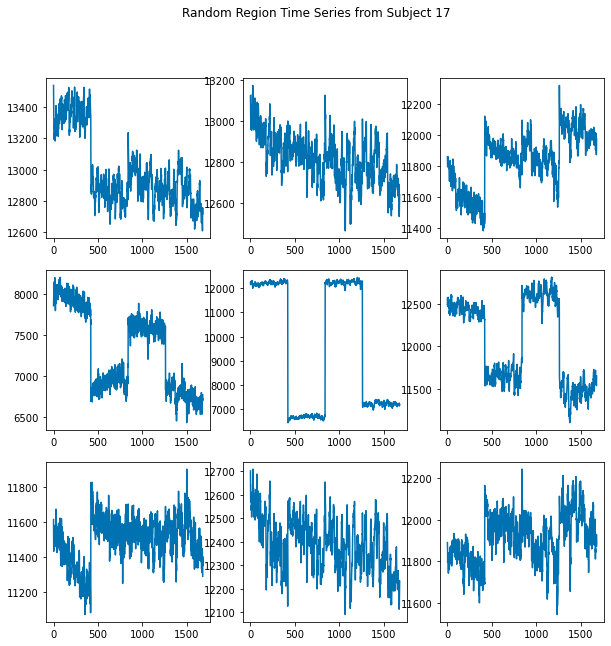

In [4]:
# Basic Visual Inspection of data
rng = np.random.default_rng() #random generator to do selection
x=np.arange(num_Timepoints)
#Plot regions from the same (random) subject
x_lim=3
y_lim=3 
num_subplots=x_lim*y_lim #set number of subplots 
plot_subject=rng.integers(num_Subj)
plot_regions=rng.integers(num_Regions,size=(num_subplots,1))
for ts_ind in range(num_subplots):
    plt.subplot(x_lim,y_lim,ts_ind+1)
    plt.plot(x,Time_Series_Matrix[plot_regions[ts_ind],:,plot_subject].transpose())
plt.suptitle('Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

## Standardizing each time series

The discontinuity behavior in the scans comes from the fact that this isn't one timeseries, but is instead $4$ timeseries concatenated. To deal with the differences between each of the $4$ scans the time series where also standardized (mean centered then divided by the standard deviation) within each scan. There are of course other things which might make sense to do here, for example calculating autocorrelation or removing time based trends from each time series seperately. However, standardizing each timeseries and treating the $4$ scans as $1$ is closer to the standard in the neuroscience literature literature so we'll stick with that. 


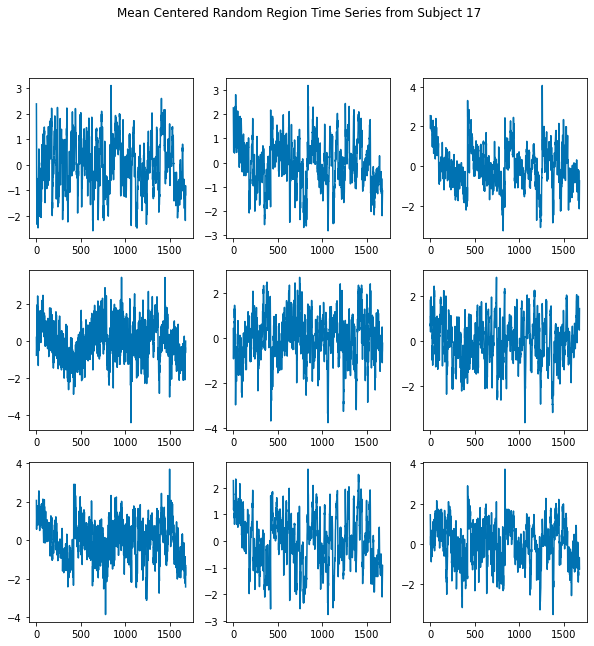

In [6]:
Time_Series_Matrix_standard=np.load(f'{data_dir}interim/Standardized_Time_Series.npy')
for ts_ind in range(num_subplots):
    plt.subplot(x_lim,y_lim,ts_ind+1)
    plt.plot(x,Time_Series_Matrix_standard[plot_regions[ts_ind],:,plot_subject].transpose())
plt.suptitle('Mean Centered Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

These look at least a little better. Following past work, let's consider the autocorrelation at lag $1$ as our feature of interest for each subject. However, before we dive into that more deeply let's see if that's a reasonable way to think about these time series. 


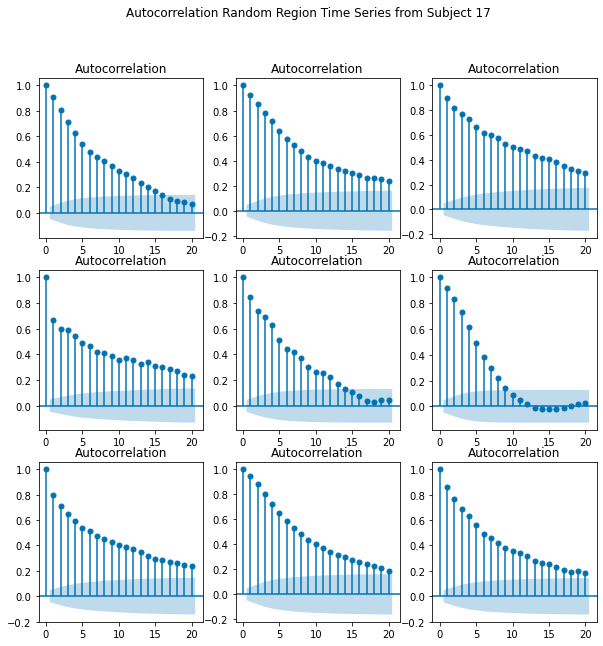

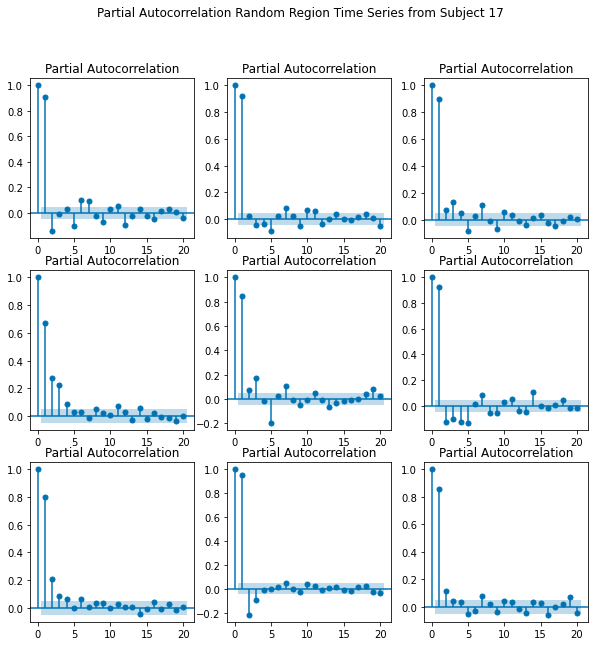

In [7]:
num_lags=20
for ts_ind in range(num_subplots):
    axis=plt.subplot(x_lim,y_lim,ts_ind+1)
    tsaplots.plot_acf(Time_Series_Matrix_standard[plot_regions[ts_ind],:,plot_subject].transpose(),ax=axis, lags=num_lags)
plt.suptitle('Autocorrelation Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

for ts_ind in range(num_subplots):
    axis=plt.subplot(x_lim,y_lim,ts_ind+1)
    tsaplots.plot_pacf(Time_Series_Matrix_standard[plot_regions[ts_ind],:,plot_subject].transpose(),ax=axis, lags=num_lags)
plt.suptitle('Partial Autocorrelation Random Region Time Series from Subject {}'.format(plot_subject))
plt.show()

The autocorrelation plots show that there's a significant degree of autocorrelation, in some cases up to num_lags, however we can see from the partial autocorrelation function that a great deal of the autocorrelation is mediated by the lag $1$ timeseries. In an ideal world, I'd probably fit a higher order autoregressive model to these data but based on these plots and for the sake of matching the literature using a lag of $1$ seems reasonable for these data. 